In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

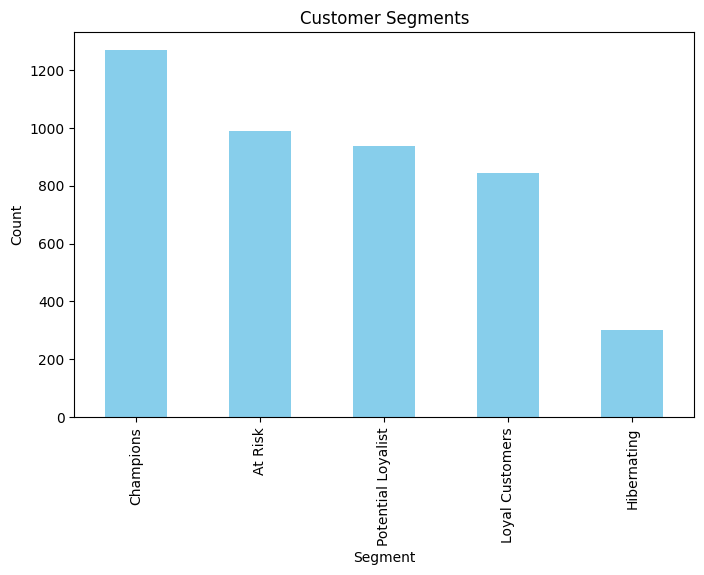

In [3]:
# Step 1: Load dataset
df = pd.read_excel("Online Retail II.xlsx.xlsx", sheet_name="Year 2010-2011")

# Step 2: Clean data
df = df[df['Customer ID'].notnull()]
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Step 3: Convert dates
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Step 4: Compute RFM metrics
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                    # Frequency
    'Quantity': lambda x: (x * df.loc[x.index, 'Price']).sum()  # Monetary
})

rfm.rename(columns={'InvoiceDate':'Recency','Invoice':'Frequency','Quantity':'Monetary'}, inplace=True)

# Step 5: Create RFM scores using quantiles
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4]).astype(int)

rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].sum(axis=1)

# Step 6: Assign segment labels
def segment_customer(score):
    if score >= 10:
        return 'Champions'
    elif score >= 8:
        return 'Loyal Customers'
    elif score >= 6:
        return 'Potential Loyalist'
    elif score >= 4:
        return 'At Risk'
    else:
        return 'Hibernating'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

# Step 7: Visualization
plt.figure(figsize=(8,5))
rfm['Segment'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Customer Segments")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.show()

# Step 8: Export results
rfm.to_csv("rfm_segments.csv")

# Write business actions
actions = {
    "Champions": ["Reward them with loyalty programs", "Exclusive offers", "Early access to new products"],
    "Loyal Customers": ["Upsell premium products", "Encourage referrals", "Provide personalized recommendations"],
    "Potential Loyalist": ["Offer discounts", "Send engagement emails", "Promote subscription plans"],
    "At Risk": ["Win-back campaigns", "Feedback surveys", "Special discounts to re-engage"],
    "Hibernating": ["Reactivation emails", "Seasonal promotions", "Highlight trending products"]
}

with open("segment_actions.txt", "w") as f:
    for seg, acts in actions.items():
        f.write(f"{seg}:\n")
        for act in acts:
            f.write(f"- {act}\n")
        f.write("\n")